In [1]:
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Load dataset
df = pd.read_csv("../data/train.csv")

# Drop irrelevant columns
df.drop(["PassengerId", "Name"], axis=1, inplace=True, errors="ignore")

# Handle missing values
for col in ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    df[col] = df[col].fillna(df[col].mean())

for col in ["HomePlanet", "CryoSleep", "Destination", "VIP"]:
    df[col] = df[col].fillna(df[col].mode()[0])

# Feature Engineering
df[["Deck", "CabinNumber", "Side"]] = df["Cabin"].str.split("/", expand=True)
df["CabinNumber"] = pd.to_numeric(df["CabinNumber"], errors="coerce").fillna(0)
df.drop("Cabin", axis=1, inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, columns=["HomePlanet", "Destination", "CryoSleep", "VIP", "Deck", "Side"], drop_first=True)

# Separate features and target
X = df.drop("Transported", axis=1)
y = df["Transported"]

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_2723/3132859492.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [3]:
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
    }

    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return accuracy_score(y_val, y_pred)

In [4]:
# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Run the optimization
study.optimize(objective, n_trials=50)

# Print the best parameters and accuracy
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-03-17 16:48:08,718] A new study created in memory with name: no-name-7608759b-a424-43d0-b3f3-b273c6a10194
[I 2025-03-17 16:48:10,985] Trial 0 finished with value: 0.8067855089131685 and parameters: {'iterations': 676, 'depth': 3, 'learning_rate': 0.2435072207508013, 'l2_leaf_reg': 4.732523420590484, 'border_count': 58, 'random_strength': 3.372726666836917}. Best is trial 0 with value: 0.8067855089131685.
[I 2025-03-17 16:48:15,062] Trial 1 finished with value: 0.7998849913743531 and parameters: {'iterations': 893, 'depth': 9, 'learning_rate': 0.06596079818713481, 'l2_leaf_reg': 4.170559861030418, 'border_count': 89, 'random_strength': 8.050047435438625}. Best is trial 0 with value: 0.8067855089131685.
[I 2025-03-17 16:48:16,266] Trial 2 finished with value: 0.7998849913743531 and parameters: {'iterations': 368, 'depth': 8, 'learning_rate': 0.06036082599946194, 'l2_leaf_reg': 8.311983604263933, 'border_count': 76, 'random_strength': 8.632326812992355}. Best is trial 0 with value

Best parameters: {'iterations': 641, 'depth': 5, 'learning_rate': 0.11911810118629372, 'l2_leaf_reg': 2.2142470476058262, 'border_count': 191, 'random_strength': 0.21062182979537525}
Best accuracy: 0.8177113283496262


/tmp/ipykernel_2723/3376962141.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


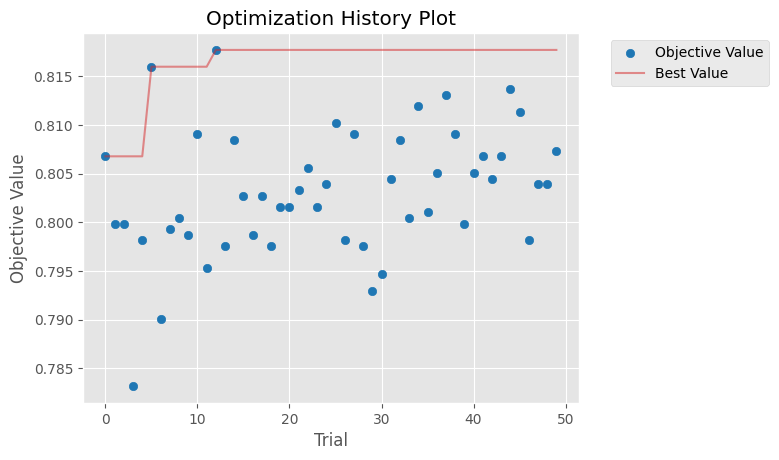

In [10]:
# Plot optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

In [11]:
# Train the final model with the best parameters
best_model = CatBoostClassifier(**study.best_params, verbose=0)
best_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8177


In [12]:
# Save the model
best_model.save_model("../model/best_model.cbm")
print("Model saved to ../model/best_model.cbm")

Model saved to ../model/best_model.cbm


In [13]:
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
print(importance_df.sort_values(by="Importance", ascending=False))

                      Feature  Importance
6                 CabinNumber   13.103805
4                         Spa   11.491636
5                      VRDeck   10.194090
0                         Age    9.633551
11             CryoSleep_True    9.578349
1                 RoomService    7.981457
2                   FoodCourt    7.077958
3                ShoppingMall    5.632045
20                     Side_S    4.222977
7           HomePlanet_Europa    4.163314
8             HomePlanet_Mars    3.658351
18                     Deck_G    3.350244
14                     Deck_C    2.319118
16                     Deck_E    2.244844
10    Destination_TRAPPIST-1e    1.568276
17                     Deck_F    1.534428
13                     Deck_B    0.967079
9   Destination_PSO J318.5-22    0.772347
15                     Deck_D    0.329594
12                   VIP_True    0.176409
19                     Deck_T    0.000129
